# Import Statements

In [ ]:
# %pip install mlxtend --upgrade

In [ ]:
import numpy as np
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import fpmax
from mlxtend.preprocessing import TransactionEncoder

import networkx as nx

# Data Preprocessing

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
links_df = pd.read_csv("/content/drive/MyDrive/ml-latest-small/links.csv", skipinitialspace=True)
movies_df = pd.read_csv("/content/drive/MyDrive/ml-latest-small/movies.csv", skipinitialspace=True)
ratings_df = pd.read_csv("/content/drive/MyDrive/ml-latest-small/ratings.csv", skipinitialspace=True)
tags_df = pd.read_csv("/content/drive/MyDrive/ml-latest-small/tags.csv", skipinitialspace=True)

## *links_df*

In [ ]:
# links_df: unneeded dataset
links_df

movieId   imdbId    tmdbId
0           1   114709     862.0
1           2   113497    8844.0
2           3   113228   15602.0
3           4   114885   31357.0
4           5   113041   11862.0
...       ...      ...       ...
9737   193581  5476944  432131.0
9738   193583  5914996  445030.0
9739   193585  6397426  479308.0
9740   193587  8391976  483455.0
9741   193609   101726   37891.0

[9742 rows x 3 columns]

## *movies_df*

In [ ]:
movies_df

movieId  ...                                       genres
0           1  ...  Adventure|Animation|Children|Comedy|Fantasy
1           2  ...                   Adventure|Children|Fantasy
2           3  ...                               Comedy|Romance
3           4  ...                         Comedy|Drama|Romance
4           5  ...                                       Comedy
...       ...  ...                                          ...
9737   193581  ...              Action|Animation|Comedy|Fantasy
9738   193583  ...                     Animation|Comedy|Fantasy
9739   193585  ...                                        Drama
9740   193587  ...                             Action|Animation
9741   193609  ...                                       Comedy

[9742 rows x 3 columns]

In [ ]:
# extracting 'release year' feature from 'title'
movies_df['title'] = movies_df['title'].str.strip()
movies_df['release year'] = np.nan
for idx in range(len(movies_df['title'])):
  if movies_df['title'][idx][-5:-1].isnumeric() == True:
    movies_df['release year'][idx] = movies_df['title'][idx][-5:-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
movies_df['release period'] = pd.cut(movies_df['release year'], 10, precision=0).astype(str)

In [ ]:
movies_df.drop(['release year'], axis=1, inplace=True)
movies_df

movieId  ...    release period
0           1  ...  (1995.0, 2006.0]
1           2  ...  (1995.0, 2006.0]
2           3  ...  (1995.0, 2006.0]
3           4  ...  (1995.0, 2006.0]
4           5  ...  (1995.0, 2006.0]
...       ...  ...               ...
9737   193581  ...  (2006.0, 2018.0]
9738   193583  ...  (2006.0, 2018.0]
9739   193585  ...  (2006.0, 2018.0]
9740   193587  ...  (2006.0, 2018.0]
9741   193609  ...  (1983.0, 1995.0]

[9742 rows x 4 columns]

In [ ]:
# one-hot encoding of genre
category_df = movies_df.genres.str.get_dummies(sep='|')
category_df

(no genres listed)  Action  Adventure  ...  Thriller  War  Western
0                      0       0          1  ...         0    0        0
1                      0       0          1  ...         0    0        0
2                      0       0          0  ...         0    0        0
3                      0       0          0  ...         0    0        0
4                      0       0          0  ...         0    0        0
...                  ...     ...        ...  ...       ...  ...      ...
9737                   0       1          0  ...         0    0        0
9738                   0       0          0  ...         0    0        0
9739                   0       0          0  ...         0    0        0
9740                   0       1          0  ...         0    0        0
9741                   0       0          0  ...         0    0        0

[9742 rows x 20 columns]

In [ ]:
# replacing one-hot encoded genres with multi-lable 'genres' column
movies_df = pd.concat([movies_df, category_df], axis=1).drop('genres', axis=1)
movies_df

movieId                                      title  ... War  Western
0           1                           Toy Story (1995)  ...   0        0
1           2                             Jumanji (1995)  ...   0        0
2           3                    Grumpier Old Men (1995)  ...   0        0
3           4                   Waiting to Exhale (1995)  ...   0        0
4           5         Father of the Bride Part II (1995)  ...   0        0
...       ...                                        ...  ...  ..      ...
9737   193581  Black Butler: Book of the Atlantic (2017)  ...   0        0
9738   193583               No Game No Life: Zero (2017)  ...   0        0
9739   193585                               Flint (2017)  ...   0        0
9740   193587        Bungo Stray Dogs: Dead Apple (2018)  ...   0        0
9741   193609        Andrew Dice Clay: Dice Rules (1991)  ...   0        0

[9742 rows x 23 columns]

## *ratings_df*

In [ ]:
ratings_df

userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]

In [ ]:
# date-time conversion
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df

userId  movieId  rating           timestamp
0            1        1     4.0 2000-07-30 18:45:03
1            1        3     4.0 2000-07-30 18:20:47
2            1        6     4.0 2000-07-30 18:37:04
3            1       47     5.0 2000-07-30 19:03:35
4            1       50     5.0 2000-07-30 18:48:51
...        ...      ...     ...                 ...
100831     610   166534     4.0 2017-05-03 21:53:22
100832     610   168248     5.0 2017-05-03 22:21:31
100833     610   168250     5.0 2017-05-08 19:50:47
100834     610   168252     5.0 2017-05-03 21:19:12
100835     610   170875     3.0 2017-05-03 21:20:15

[100836 rows x 4 columns]

In [ ]:
# extracting year from timestamp
ratings_df['timestamp'] = ratings_df['timestamp'].astype(str).str.split(' ', 1, expand=True).iloc[:, 0]
ratings_df[['rating year']] = ratings_df['timestamp'].str.split('-', 1, expand=True).iloc[:, :1]
ratings_df.drop(columns=['timestamp'], inplace=True)

## *tags_df*

In [ ]:
tags_df

userId  movieId               tag   timestamp
0          2    60756             funny  1445714994
1          2    60756   Highly quotable  1445714996
2          2    60756      will ferrell  1445714992
3          2    89774      Boxing story  1445715207
4          2    89774               MMA  1445715200
...      ...      ...               ...         ...
3678     606     7382         for katie  1171234019
3679     606     7936           austere  1173392334
3680     610     3265            gun fu  1493843984
3681     610     3265  heroic bloodshed  1493843978
3682     610   168248  Heroic Bloodshed  1493844270

[3683 rows x 4 columns]

In [ ]:
# dropping timestamp: unneeded column
tags_df.drop(columns=['timestamp'], inplace=True)

In [ ]:
# combine multiple tags
tags_df['tag'] = tags_df.groupby(['userId','movieId'])['tag'].transform(lambda x: '|'.join(x))
tags_df = tags_df.drop_duplicates()
tags_df

userId  movieId                                      tag
0          2    60756       funny|Highly quotable|will ferrell
3          2    89774               Boxing story|MMA|Tom Hardy
6          2   106782  drugs|Leonardo DiCaprio|Martin Scorsese
9          7    48516                             way too long
10        18      431                 Al Pacino|gangster|mafia
...      ...      ...                                      ...
3677     606     6107                             World War II
3678     606     7382                                for katie
3679     606     7936                                  austere
3680     610     3265                  gun fu|heroic bloodshed
3682     610   168248                         Heroic Bloodshed

[1775 rows x 3 columns]

In [ ]:
# one-hot encoding of tag
tag_df = tags_df.tag.str.get_dummies(sep='|')
tag_df

"artsy"  06 Oscar Nominated Best Movie - Animation  ...  zoe kazan  zombies
0           0                                          0  ...          0        0
3           0                                          0  ...          0        0
6           0                                          0  ...          0        0
9           0                                          0  ...          0        0
10          0                                          0  ...          0        0
...       ...                                        ...  ...        ...      ...
3677        0                                          0  ...          0        0
3678        0                                          0  ...          0        0
3679        0                                          0  ...          0        0
3680        0                                          0  ...          0        0
3682        0                                          0  ...          0        0

[1775 rows x 1589 columns]

In [ ]:
# replacing one-hot encoded genres with multi-lable 'genres' column
tags_df = pd.concat([tags_df, tag_df], axis=1).drop('tag', axis=1)
tags_df

userId  movieId  "artsy"  ...  zither  zoe kazan  zombies
0          2    60756        0  ...       0          0        0
3          2    89774        0  ...       0          0        0
6          2   106782        0  ...       0          0        0
9          7    48516        0  ...       0          0        0
10        18      431        0  ...       0          0        0
...      ...      ...      ...  ...     ...        ...      ...
3677     606     6107        0  ...       0          0        0
3678     606     7382        0  ...       0          0        0
3679     606     7936        0  ...       0          0        0
3680     610     3265        0  ...       0          0        0
3682     610   168248        0  ...       0          0        0

[1775 rows x 1591 columns]

# EDA

## *movies_df*

### null values

In [ ]:
movies_df

movieId                                      title  ... War  Western
0           1                           Toy Story (1995)  ...   0        0
1           2                             Jumanji (1995)  ...   0        0
2           3                    Grumpier Old Men (1995)  ...   0        0
3           4                   Waiting to Exhale (1995)  ...   0        0
4           5         Father of the Bride Part II (1995)  ...   0        0
...       ...                                        ...  ...  ..      ...
9737   193581  Black Butler: Book of the Atlantic (2017)  ...   0        0
9738   193583               No Game No Life: Zero (2017)  ...   0        0
9739   193585                               Flint (2017)  ...   0        0
9740   193587        Bungo Stray Dogs: Dead Apple (2018)  ...   0        0
9741   193609        Andrew Dice Clay: Dice Rules (1991)  ...   0        0

[9742 rows x 23 columns]

In [ ]:
movies_df.isna().sum()

movieId               0
title                 0
release period        0
(no genres listed)    0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
IMAX                  0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
dtype: int64

In [ ]:
len(movies_df[movies_df['release period'] == 'nan'])

12

In [ ]:
movies_df['release period'] = movies_df['release period'].astype('category')

### duplicates

In [ ]:
movies_df.duplicated().sum()

0

### plots 

In [ ]:
movies_df.describe(include='object')

title
count          9742
unique         9737
top     Eros (2004)
freq              2

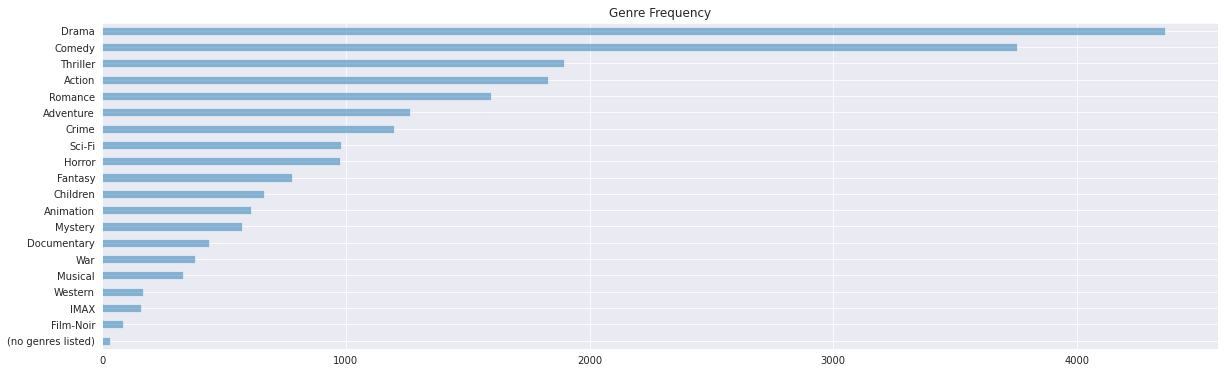

In [ ]:
genre_columns = list(movies_df.drop(['movieId', 'title', 'release period'], axis=1))
movies_df[genre_columns].sum().sort_values(ascending=True).plot(kind='barh',figsize=(20,6), alpha=0.5, title='Genre Frequency')

### correlation

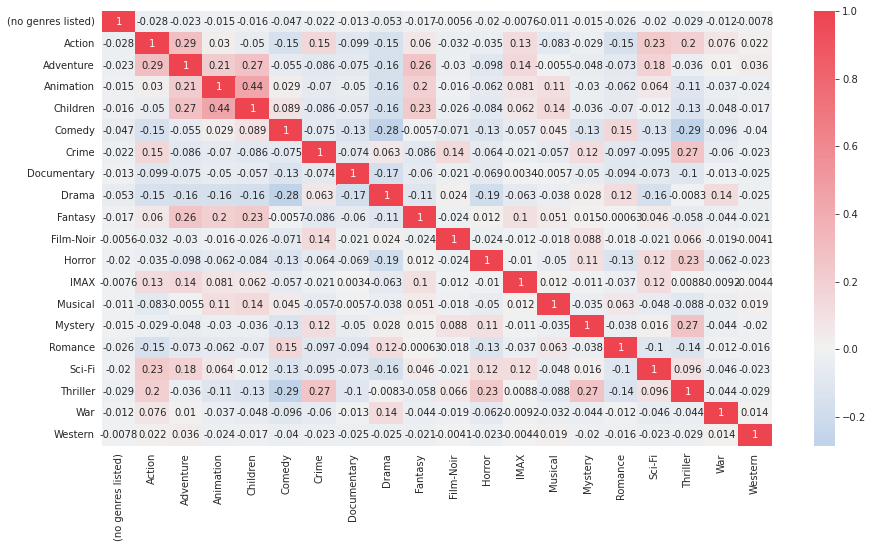

In [ ]:
#correlation matrix
corrmat= movies_df.drop(['movieId', 'title', 'release period'], axis=1).corr()
plt.figure(figsize=(15,8)) 

cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

## *ratings_df*

### null values

In [ ]:
ratings_df

userId  movieId  rating rating year
0            1        1     4.0        2000
1            1        3     4.0        2000
2            1        6     4.0        2000
3            1       47     5.0        2000
4            1       50     5.0        2000
...        ...      ...     ...         ...
100831     610   166534     4.0        2017
100832     610   168248     5.0        2017
100833     610   168250     5.0        2017
100834     610   168252     5.0        2017
100835     610   170875     3.0        2017

[100836 rows x 4 columns]

In [ ]:
ratings_df.isna().sum()

userId         0
movieId        0
rating         0
rating year    0
dtype: int64

In [ ]:
ratings_df.dtypes

userId           int64
movieId          int64
rating         float64
rating year     object
dtype: object

In [ ]:
ratings_df['rating year'] = ratings_df['rating year'].astype(np.int64)

### duplicates

In [ ]:
ratings_df.duplicated().sum()

0

In [ ]:
len(ratings_df.groupby(['userId','movieId']).filter(lambda x: len(x) > 1))

0

In [ ]:
ratings_df.drop(['rating year'], axis=1, inplace=True)

### plots

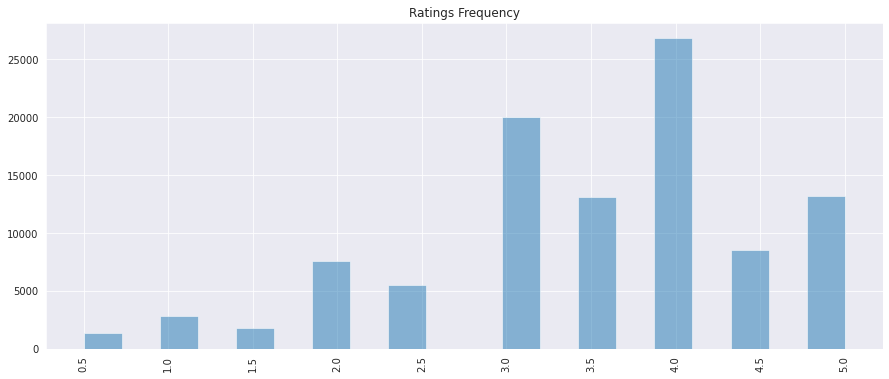

In [ ]:
plt.figure(figsize=(15,6)) 
plt.title('Ratings Frequency')
plt.xticks(rotation=90)
plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
ratings_df['rating'].hist(bins=20, alpha=0.5)
plt.show()

In [ ]:
users_rating_df = pd.DataFrame(ratings_df.groupby('userId')['rating'].mean()).T
users_rating_df

userId       1         2         3    ...       608      609       610
rating  4.366379  3.948276  2.435897  ...  3.134176  3.27027  3.688556

[1 rows x 610 columns]

In [ ]:
# users_columns = list(users_rating_df)
# ax = users_rating_df[users_columns].sum().sort_values(ascending=True).plot(kind='barh',figsize=(10,100), alpha=0.8, title='Mean User Ratings')
# ax.figure.savefig('mean_users_ratings.pdf')

In [ ]:
movies_rating_df = pd.DataFrame(ratings_df.groupby('movieId')['rating'].mean()).T
movies_rating_df

movieId   1         2         3         4       ...  193583  193585  193587  193609
rating   3.92093  3.431818  3.259615  2.357143  ...     3.5     3.5     3.5     4.0

[1 rows x 9724 columns]

In [ ]:
# movies_columns = list(movies_rating_df)
# ax = movies_rating_df[movies_columns].sum().sort_values(ascending=True).plot(kind='barh',figsize=(10,800), alpha=0.8, title='Mean Movie Ratings')
# ax.figure.savefig('mean_movie_ratings.pdf')

## *tags_df*

### null values

In [ ]:
tags_df

userId  movieId  "artsy"  ...  zither  zoe kazan  zombies
0          2    60756        0  ...       0          0        0
3          2    89774        0  ...       0          0        0
6          2   106782        0  ...       0          0        0
9          7    48516        0  ...       0          0        0
10        18      431        0  ...       0          0        0
...      ...      ...      ...  ...     ...        ...      ...
3677     606     6107        0  ...       0          0        0
3678     606     7382        0  ...       0          0        0
3679     606     7936        0  ...       0          0        0
3680     610     3265        0  ...       0          0        0
3682     610   168248        0  ...       0          0        0

[1775 rows x 1591 columns]

In [ ]:
print(tags_df.isna().sum())
print('Total null values: ', sum(tags_df.isna().sum()))

userId                                       0
movieId                                      0
"artsy"                                      0
06 Oscar Nominated Best Movie - Animation    0
1900s                                        0
                                            ..
wry                                          0
younger men                                  0
zither                                       0
zoe kazan                                    0
zombies                                      0
Length: 1591, dtype: int64
Total null values:  0


### duplicates

In [ ]:
tags_df.duplicated().sum()

0

### plots

In [ ]:
tag_columns = list(tags_df.drop(['userId', 'movieId'], axis=1))
# ax = tags_df[tag_columns].sum().sort_values(ascending=True).plot(kind='barh',figsize=(10,500), alpha=0.8, title='Tag Frequency')
# ax.figure.savefig('tag_frequency.pdf')

In [ ]:
# keeping only top tags
tags_freq_df = pd.DataFrame(tags_df[tag_columns].sum(), columns=['freq'])
dropped_tags = list(tags_freq_df[tags_freq_df['freq'] <= 10].T)
tags_df.drop(columns=dropped_tags, axis=1, inplace=True)
tags_df

userId  movieId  Disney  ...  time travel  twist ending  visually appealing
0          2    60756       0  ...            0             0                   0
3          2    89774       0  ...            0             0                   0
6          2   106782       0  ...            0             0                   0
9          7    48516       0  ...            0             0                   0
10        18      431       0  ...            0             0                   0
...      ...      ...     ...  ...          ...           ...                 ...
3677     606     6107       0  ...            0             0                   0
3678     606     7382       0  ...            0             0                   0
3679     606     7936       0  ...            0             0                   0
3680     610     3265       0  ...            0             0                   0
3682     610   168248       0  ...            0             0                   0

[1775 rows x 48 columns]

### correlation

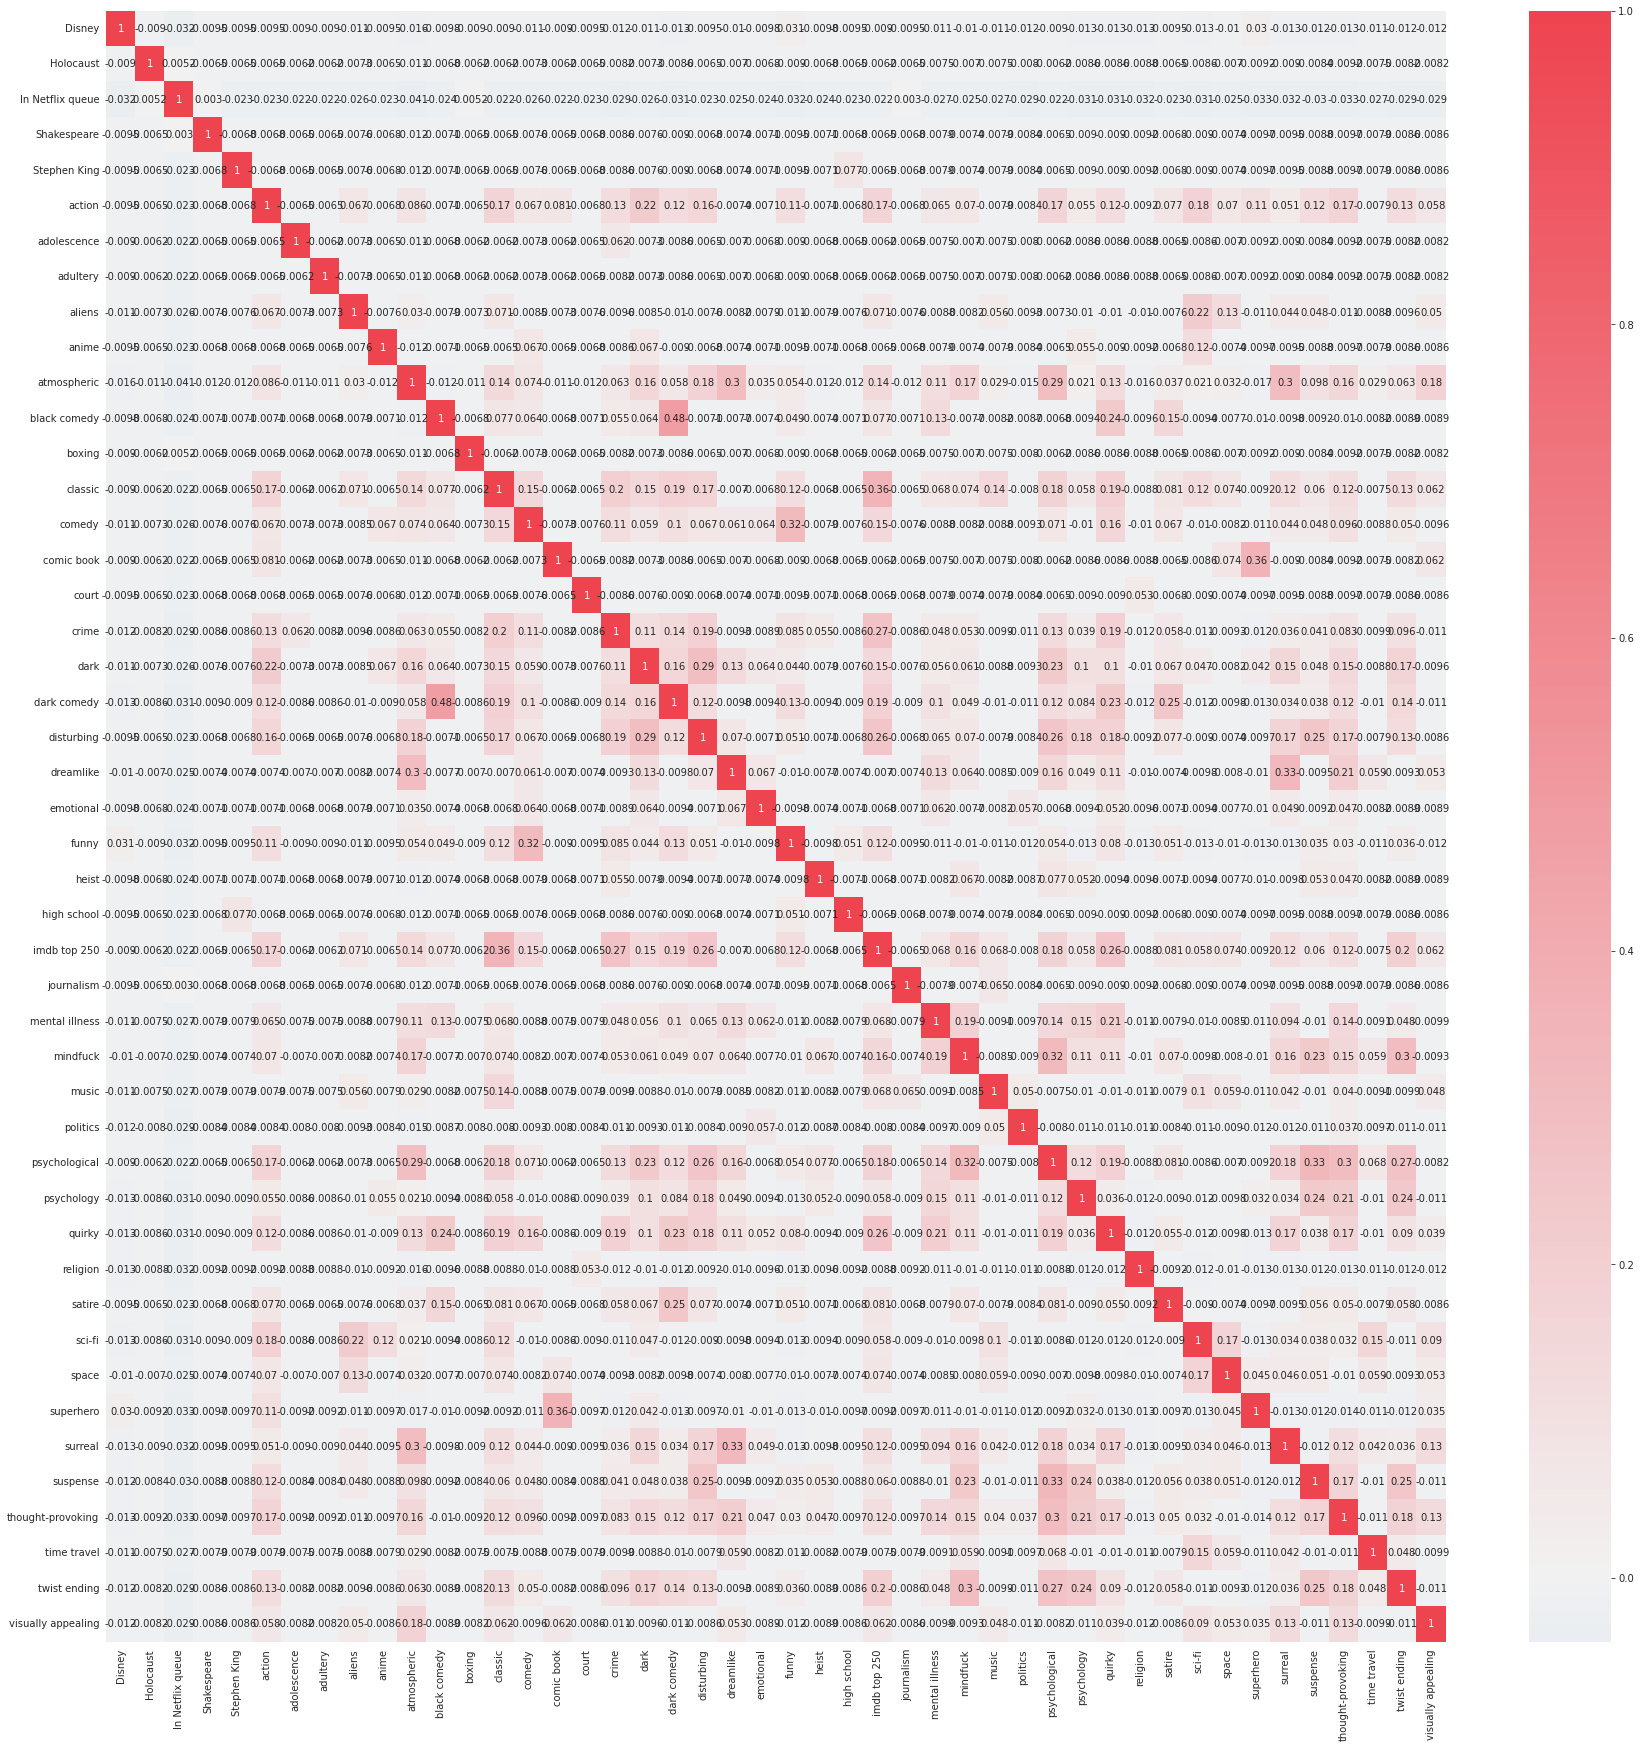

In [ ]:
#correlation matrix
corrmat= tags_df.drop(['userId', 'movieId'], axis=1).corr()
plt.figure(figsize=(30,30))

cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)
svm = sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)
figure = svm.get_figure()    
figure.savefig('tags_correlation.pdf', dpi=400)

# Association Rule

## Transcation Data

### watched movies with rating >= 3

In [ ]:
movies_df

movieId                                      title  ... War  Western
0           1                           Toy Story (1995)  ...   0        0
1           2                             Jumanji (1995)  ...   0        0
2           3                    Grumpier Old Men (1995)  ...   0        0
3           4                   Waiting to Exhale (1995)  ...   0        0
4           5         Father of the Bride Part II (1995)  ...   0        0
...       ...                                        ...  ...  ..      ...
9737   193581  Black Butler: Book of the Atlantic (2017)  ...   0        0
9738   193583               No Game No Life: Zero (2017)  ...   0        0
9739   193585                               Flint (2017)  ...   0        0
9740   193587        Bungo Stray Dogs: Dead Apple (2018)  ...   0        0
9741   193609        Andrew Dice Clay: Dice Rules (1991)  ...   0        0

[9742 rows x 23 columns]

In [ ]:
ratings_df_3above = ratings_df[ratings_df.rating >= 3.0]
ratings_df_3above

userId  movieId  rating
0            1        1     4.0
1            1        3     4.0
2            1        6     4.0
3            1       47     5.0
4            1       50     5.0
...        ...      ...     ...
100831     610   166534     4.0
100832     610   168248     5.0
100833     610   168250     5.0
100834     610   168252     5.0
100835     610   170875     3.0

[81763 rows x 3 columns]

In [ ]:
watched_movies_3above = movies_df.merge(ratings_df_3above, on = ['movieId'], how = 'inner')
watched_movies_3above

movieId                                      title  ... userId  rating
0            1                           Toy Story (1995)  ...      1     4.0
1            1                           Toy Story (1995)  ...      5     4.0
2            1                           Toy Story (1995)  ...      7     4.5
3            1                           Toy Story (1995)  ...     17     4.5
4            1                           Toy Story (1995)  ...     18     3.5
...        ...                                        ...  ...    ...     ...
81758   193581  Black Butler: Book of the Atlantic (2017)  ...    184     4.0
81759   193583               No Game No Life: Zero (2017)  ...    184     3.5
81760   193585                               Flint (2017)  ...    184     3.5
81761   193587        Bungo Stray Dogs: Dead Apple (2018)  ...    184     3.5
81762   193609        Andrew Dice Clay: Dice Rules (1991)  ...    331     4.0

[81763 rows x 25 columns]

In [ ]:
watched_movies_3above = watched_movies_3above[['title', 'userId']]
watched_movies_3above

title  userId
0                               Toy Story (1995)       1
1                               Toy Story (1995)       5
2                               Toy Story (1995)       7
3                               Toy Story (1995)      17
4                               Toy Story (1995)      18
...                                          ...     ...
81758  Black Butler: Book of the Atlantic (2017)     184
81759               No Game No Life: Zero (2017)     184
81760                               Flint (2017)     184
81761        Bungo Stray Dogs: Dead Apple (2018)     184
81762        Andrew Dice Clay: Dice Rules (1991)     331

[81763 rows x 2 columns]

In [ ]:
watched_movies_3above_list = pd.DataFrame(watched_movies_3above.groupby(['userId'])['title'].apply(list).reset_index()['title'])
watched_movies_3above_list

title
0    [Toy Story (1995), Grumpier Old Men (1995), He...
1    [Shawshank Redemption, The (1994), Tommy Boy (...
2    [Escape from L.A. (1996), Highlander (1986), S...
3    [Get Shorty (1995), To Die For (1995), Mighty ...
4    [Toy Story (1995), Get Shorty (1995), Babe (19...
..                                                 ...
604  [Cutthroat Island (1995), Sense and Sensibilit...
605  [Toy Story (1995), American President, The (19...
606  [GoldenEye (1995), Casino (1995), Get Shorty (...
607  [Toy Story (1995), GoldenEye (1995), Bravehear...
608  [Toy Story (1995), Heat (1995), Casino (1995),...

[609 rows x 1 columns]

### same genre

In [ ]:
movies_df

movieId                                      title  ... War  Western
0           1                           Toy Story (1995)  ...   0        0
1           2                             Jumanji (1995)  ...   0        0
2           3                    Grumpier Old Men (1995)  ...   0        0
3           4                   Waiting to Exhale (1995)  ...   0        0
4           5         Father of the Bride Part II (1995)  ...   0        0
...       ...                                        ...  ...  ..      ...
9737   193581  Black Butler: Book of the Atlantic (2017)  ...   0        0
9738   193583               No Game No Life: Zero (2017)  ...   0        0
9739   193585                               Flint (2017)  ...   0        0
9740   193587        Bungo Stray Dogs: Dead Apple (2018)  ...   0        0
9741   193609        Andrew Dice Clay: Dice Rules (1991)  ...   0        0

[9742 rows x 23 columns]

In [ ]:
same_genre_movies_list = pd.DataFrame([], columns=['title'])
genre_columns = list(movies_df.drop(['movieId', 'title', 'release period', '(no genres listed)'], axis=1)) 

for column in genre_columns:
  length = len(same_genre_movies_list)
  same_genre_movies_list.at[length, 'title'] = movies_df[movies_df[column] == 1]['title'].tolist()

same_genre_movies_list

title
0   [Heat (1995), Sudden Death (1995), GoldenEye (...
1   [Toy Story (1995), Jumanji (1995), Tom and Huc...
2   [Toy Story (1995), Balto (1995), Pocahontas (1...
3   [Toy Story (1995), Jumanji (1995), Tom and Huc...
4   [Toy Story (1995), Grumpier Old Men (1995), Wa...
5   [Heat (1995), Casino (1995), Money Train (1995...
6   [Nico Icon (1995), Heidi Fleiss: Hollywood Mad...
7   [Waiting to Exhale (1995), American President,...
8   [Toy Story (1995), Jumanji (1995), City of Los...
9   [Devil in a Blue Dress (1995), Suture (1993), ...
10  [Dracula: Dead and Loving It (1995), Copycat (...
11  [Apollo 13 (1995), Lion King, The (1994), Beau...
12  [Pocahontas (1995), Muppet Treasure Island (19...
13  [Copycat (1995), City of Lost Children, The (C...
14  [Grumpier Old Men (1995), Waiting to Exhale (1...
15  [Powder (1995), City of Lost Children, The (Ci...
16  [Heat (1995), GoldenEye (1995), Money Train (1...
17  [Richard III (1995), Misérables, Les (1995), B...
18  [Desperado (1995), Wild Bill (1995), Legends o...

### same tagged movies

In [ ]:
tags_df

userId  movieId  Disney  ...  time travel  twist ending  visually appealing
0          2    60756       0  ...            0             0                   0
3          2    89774       0  ...            0             0                   0
6          2   106782       0  ...            0             0                   0
9          7    48516       0  ...            0             0                   0
10        18      431       0  ...            0             0                   0
...      ...      ...     ...  ...          ...           ...                 ...
3677     606     6107       0  ...            0             0                   0
3678     606     7382       0  ...            0             0                   0
3679     606     7936       0  ...            0             0                   0
3680     610     3265       0  ...            0             0                   0
3682     610   168248       0  ...            0             0                   0

[1775 rows x 48 columns]

In [ ]:
watched_movies_sametag = tags_df.merge(movies_df[['movieId', 'title']], on = ['movieId'], how = 'inner')
watched_movies_sametag

userId  ...                                              title
0          2  ...                               Step Brothers (2008)
1         62  ...                               Step Brothers (2008)
2        424  ...                               Step Brothers (2008)
3          2  ...                                     Warrior (2011)
4          2  ...                    Wolf of Wall Street, The (2013)
...      ...  ...                                                ...
1770     606  ...                                   Tom Jones (1963)
1771     606  ...                               Staying Alive (1983)
1772     606  ...  Night of the Shooting Stars (Notte di San Lore...
1773     606  ...                             Shame (Skammen) (1968)
1774     610  ...              Hard-Boiled (Lat sau san taam) (1992)

[1775 rows x 49 columns]

In [ ]:
watched_movies_sametag_list = pd.DataFrame([], columns=['title'])
tag_columns = list(watched_movies_sametag.drop(['userId', 'movieId', 'title', 'In Netflix queue'], axis=1))

for column in tag_columns:
  length = len(watched_movies_sametag_list)
  watched_movies_sametag_list.at[length, 'title'] = watched_movies_sametag[watched_movies_sametag[column] == 1]['title'].tolist()

watched_movies_sametag_list

### same time period movies

In [ ]:
movies_df

movieId                                      title  ... War  Western
0           1                           Toy Story (1995)  ...   0        0
1           2                             Jumanji (1995)  ...   0        0
2           3                    Grumpier Old Men (1995)  ...   0        0
3           4                   Waiting to Exhale (1995)  ...   0        0
4           5         Father of the Bride Part II (1995)  ...   0        0
...       ...                                        ...  ...  ..      ...
9737   193581  Black Butler: Book of the Atlantic (2017)  ...   0        0
9738   193583               No Game No Life: Zero (2017)  ...   0        0
9739   193585                               Flint (2017)  ...   0        0
9740   193587        Bungo Stray Dogs: Dead Apple (2018)  ...   0        0
9741   193609        Andrew Dice Clay: Dice Rules (1991)  ...   0        0

[9742 rows x 23 columns]

In [ ]:
removed_nan_movies_df = movies_df[movies_df['release period'] != 'nan']

In [ ]:
same_period_movies_list = pd.DataFrame(removed_nan_movies_df.groupby(['release period'])['title'].apply(list).reset_index()['title'])
same_period_movies_list

title
0   [Trip to the Moon, A (Voyage dans la lune, Le)...
1   [Nosferatu (Nosferatu, eine Symphonie des Grau...
2   [It Happened One Night (1934), Gay Divorcee, T...
3   [Snow White and the Seven Dwarfs (1937), Pinoc...
4   [Song of the Little Road (Pather Panchali) (19...
5   [Beauty of the Day (Belle de jour) (1967), Umb...
6   [Taxi Driver (1976), Star Wars: Episode IV - A...
7   [Lamerica (1994), Postman, The (Postino, Il) (...
8   [Toy Story (1995), Jumanji (1995), Grumpier Ol...
9   [Freedom Writers (2007), Stomp the Yard (2007)...
10                                                 []

In [ ]:
same_period_movies_list = same_period_movies_list.iloc[:-1]
same_period_movies_list

title
0  [Trip to the Moon, A (Voyage dans la lune, Le)...
1  [Nosferatu (Nosferatu, eine Symphonie des Grau...
2  [It Happened One Night (1934), Gay Divorcee, T...
3  [Snow White and the Seven Dwarfs (1937), Pinoc...
4  [Song of the Little Road (Pather Panchali) (19...
5  [Beauty of the Day (Belle de jour) (1967), Umb...
6  [Taxi Driver (1976), Star Wars: Episode IV - A...
7  [Lamerica (1994), Postman, The (Postino, Il) (...
8  [Toy Story (1995), Jumanji (1995), Grumpier Ol...
9  [Freedom Writers (2007), Stomp the Yard (2007)...

## Final 

In [ ]:
movies_list = pd.concat([watched_movies_3above_list, same_genre_movies_list, watched_movies_sametag_list, same_period_movies_list])
movies_list

title
0   [Toy Story (1995), Grumpier Old Men (1995), He...
1   [Shawshank Redemption, The (1994), Tommy Boy (...
2   [Escape from L.A. (1996), Highlander (1986), S...
3   [Get Shorty (1995), To Die For (1995), Mighty ...
4   [Toy Story (1995), Get Shorty (1995), Babe (19...
..                                                ...
5   [Beauty of the Day (Belle de jour) (1967), Umb...
6   [Taxi Driver (1976), Star Wars: Episode IV - A...
7   [Lamerica (1994), Postman, The (Postino, Il) (...
8   [Toy Story (1995), Jumanji (1995), Grumpier Ol...
9   [Freedom Writers (2007), Stomp the Yard (2007)...

[683 rows x 1 columns]

In [ ]:
movies_list = movies_list['title'].tolist()
movies_list

[['Toy Story (1995)',
  'Grumpier Old Men (1995)',
  'Heat (1995)',
  'Seven (a.k.a. Se7en) (1995)',
  'Usual Suspects, The (1995)',
  'From Dusk Till Dawn (1996)',
  'Bottle Rocket (1996)',
  'Braveheart (1995)',
  'Rob Roy (1995)',
  'Canadian Bacon (1995)',
  'Desperado (1995)',
  'Billy Madison (1995)',
  'Clerks (1994)',
  'Dumb & Dumber (Dumb and Dumber) (1994)',
  'Ed Wood (1994)',
  'Star Wars: Episode IV - A New Hope (1977)',
  'Pulp Fiction (1994)',
  'Stargate (1994)',
  'Tommy Boy (1995)',
  'Clear and Present Danger (1994)',
  'Forrest Gump (1994)',
  'Jungle Book, The (1994)',
  'Mask, The (1994)',
  'Blown Away (1994)',
  'Dazed and Confused (1993)',
  'Fugitive, The (1993)',
  'Jurassic Park (1993)',
  'Mrs. Doubtfire (1993)',
  "Schindler's List (1993)",
  'So I Married an Axe Murderer (1993)',
  'Three Musketeers, The (1993)',
  'Tombstone (1993)',
  'Dances with Wolves (1990)',
  'Batman (1989)',
  'Silence of the Lambs, The (1991)',
  'Pinocchio (1940)',
  'Fargo (1

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(movies_list).transform(movies_list)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

## Rules

In [283]:
frequent_itemsets = fpgrowth(df, min_support=0.05, use_colnames=True, max_len=2)
frequent_itemsets

support                                        itemsets
0      0.469985                           (Forrest Gump (1994))
1      0.450952                           (Pulp Fiction (1994))
2      0.395315              (Silence of the Lambs, The (1991))
3      0.383602                            (Matrix, The (1999))
4      0.354319     (Star Wars: Episode IV - A New Hope (1977))
...         ...                                             ...
23914  0.046852                 (Fight Club (1999), Elf (2003))
23915  0.046852               (Forrest Gump (1994), Elf (2003))
23916  0.045388          (Elf (2003), Kill Bill: Vol. 1 (2003))
23917  0.045388               (Finding Nemo (2003), Elf (2003))
23918  0.045388  (Elf (2003), Shawshank Redemption, The (1994))

[23919 rows x 2 columns]

In [284]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

support                                        itemsets  length
0      0.469985                           (Forrest Gump (1994))       1
1      0.450952                           (Pulp Fiction (1994))       1
2      0.395315              (Silence of the Lambs, The (1991))       1
3      0.383602                            (Matrix, The (1999))       1
4      0.354319     (Star Wars: Episode IV - A New Hope (1977))       1
...         ...                                             ...     ...
23914  0.046852                 (Fight Club (1999), Elf (2003))       2
23915  0.046852               (Forrest Gump (1994), Elf (2003))       2
23916  0.045388          (Elf (2003), Kill Bill: Vol. 1 (2003))       2
23917  0.045388               (Finding Nemo (2003), Elf (2003))       2
23918  0.045388  (Elf (2003), Shawshank Redemption, The (1994))       2

[23919 rows x 3 columns]

In [285]:
random_recommedations = frequent_itemsets[frequent_itemsets['length'] == 1].sort_values(by='support').head(50)['itemsets']
random_recommedations = random_recommedations.transform(lambda x: ''.join(x)).tolist()
random_recommedations

['Tropic Thunder (2008)',
 'There Will Be Blood (2007)',
 'Entrapment (1999)',
 'Laputa: Castle in the Sky (Tenkû no shiro Rapyuta) (1986)',
 'Hercules (1997)',
 'Arsenic and Old Lace (1944)',
 'Mystery Science Theater 3000: The Movie (1996)',
 'Titan A.E. (2000)',
 'Grand Day Out with Wallace and Gromit, A (1989)',
 'Harold and Kumar Go to White Castle (2004)',
 'Incredible Hulk, The (2008)',
 'Mallrats (1995)',
 'Captain America: The Winter Soldier (2014)',
 'Negotiator, The (1998)',
 'Hoop Dreams (1994)',
 'Rudy (1993)',
 'Insider, The (1999)',
 'John Wick (2014)',
 "Ocean's Thirteen (2007)",
 'Underworld (2003)',
 'Cruel Intentions (1999)',
 "All the President's Men (1976)",
 'Final Fantasy: The Spirits Within (2001)',
 'Yes Man (2008)',
 'The Revenant (2015)',
 'Madness of King George, The (1994)',
 'Pineapple Express (2008)',
 'Dangerous Minds (1995)',
 'Pretty in Pink (1986)',
 'Looper (2012)',
 'Life of Pi (2012)',
 'Philadelphia Story, The (1940)',
 'Johnny Mnemonic (1995)',
 

In [286]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.01)
rules

antecedents  ... conviction
0                   (Forrest Gump (1994))  ...   1.587788
1                   (Pulp Fiction (1994))  ...   1.665760
2                   (Pulp Fiction (1994))  ...   1.719253
3      (Shawshank Redemption, The (1994))  ...   1.657603
4                   (Pulp Fiction (1994))  ...   1.619505
...                                   ...  ...        ...
46243          (Kill Bill: Vol. 1 (2003))  ...   1.245440
46244               (Finding Nemo (2003))  ...   1.209182
46245                        (Elf (2003))  ...   3.533431
46246                        (Elf (2003))  ...   2.381650
46247  (Shawshank Redemption, The (1994))  ...   1.043478

[46248 rows x 9 columns]

In [ ]:
fig, ax=plt.subplots(figsize=(200,80))
GA=nx.from_pandas_edgelist(rules,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.savefig('rules.png',dpi=100)
plt.show()

# Prediction

In [280]:
test_df = pd.read_csv("/content/drive/MyDrive/ml-latest-small/sample_test.csv", skipinitialspace=True)
test_df

movies
0                              Toy Story (1995)
1                                Jumanji (1995)
2                       Grumpier Old Men (1995)
3                      Waiting to Exhale (1995)
4            Father of the Bride Part II (1995)
...                                         ...
9737  Black Butler: Book of the Atlantic (2017)
9738               No Game No Life: Zero (2017)
9739                               Flint (2017)
9740        Bungo Stray Dogs: Dead Apple (2018)
9741        Andrew Dice Clay: Dice Rules (1991)

[9742 rows x 1 columns]

In [281]:
def predict(movies_history):
  movie_list = movies_history.splitlines()
  recommendation_df = pd.DataFrame([], columns=['consequents','lift'])

  for movie in movie_list:
    recommendation_df = pd.concat([recommendation_df, rules[rules["antecedents"].apply(lambda x: movie in str(x))]])[['consequents','lift']]
  
  recommendation_df.groupby('consequents', group_keys=False).apply(lambda x: x.loc[x.lift.idxmax()])
  recommendation_df = recommendation_df.sort_values(ascending=False,by='lift').head(4).reset_index().drop(['index'], axis=1)

  recommendation_df = recommendation_df['consequents'].transform(lambda x: '\n'.join(x)).tolist()
  if (len(recommendation_df) < 4):
    random.seed(42)
    recommendation_df = recommendation_df + random.sample(random_recommedations, 4-len(recommendation_df))

  return recommendation_df

In [ ]:
recommendation_list = []
for movies_history in test_df['movies']:
  recommendation_list.append('\n'.join(predict(movies_history)))
  
test_df['recommendation_prediction'] = pd.Series(recommendation_list)
test_df

In [279]:
test_df.to_csv('/content/drive/MyDrive/ml-latest-small/sample_test.csv', encoding='utf-8', index=False)

# Maximal Frequent

In [289]:
maximal_frequent=fpmax(df, min_support=0.05,use_colnames=True)
maximal_rules

KeyboardInterrupt: ignored

In [ ]:
maximal_frequent

In [ ]:
maximal_rules = association_rules(maximal_frequent,metric="lift",min_threshold=0.01,support_only=True)
maximal_rules

In [ ]:
fig, ax=plt.subplots(figsize=(200,80))
GA=nx.from_pandas_edgelist(maximal_rules,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.legend()
plt.savefig('maximal_itemset.png',dpi=100)
plt.show()